In [5]:
# --- Import all libraries ---
import pandas as pd
import numpy as np
import re
import string
import random
import unicodedata
from spellchecker import SpellChecker
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import T5Tokenizer, T5ForConditionalGeneration
from bert_score import score
from rouge_score import rouge_scorer

In [6]:
# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
!pip install pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.6 MB/s eta 0:00:00


In [4]:
!pip install bert-score rouge-score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24

In [7]:
df = pd.read_csv("Processed_dataset.csv")

In [8]:
# --- Load BART ---
bart_model_name = "facebook/bart-large-cnn"
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name).to(device)

def bart_summarize_batch(texts, max_input_length=1024, max_output_length=50):
    inputs = bart_tokenizer(
        texts,
        max_length=max_input_length,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}
    summary_ids = bart_model.generate(
        inputs["input_ids"],
        num_beams=4,
        length_penalty=2.0,
        max_length=max_output_length,
        min_length=1,
        no_repeat_ngram_size=3,
        early_stopping=True
    )
    return [bart_tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [9]:
# --- Load Pegasus ---
pegasus_model_name = "google/pegasus-xsum"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to(device)

def pegasus_summarize(tweet):
    if pd.isna(tweet) or not str(tweet).strip():
        return ""
    input_ids = pegasus_tokenizer.encode(str(tweet), return_tensors="pt", truncation=True, max_length=128).to(device)
    summary_ids = pegasus_model.generate(input_ids, max_length=32, num_beams=4, early_stopping=True)
    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [10]:
# --- Load T5 ---
t5_model_name = "t5-small"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)

def t5_summarize(tweet):
    input_text = "summarize: " + str(tweet)
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
    output_ids = t5_model.generate(input_ids, max_length=32, num_beams=4, early_stopping=True)
    return t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [11]:
# --- Generate summaries ---

batch_size = 16
texts = df["Tweets"].astype(str).tolist()

# BART summaries
print("Generating BART summaries...")
bart_summaries = []
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_summaries = bart_summarize_batch(batch_texts)
    bart_summaries.extend(batch_summaries)
    print(f"BART: Processed {i + len(batch_texts)} / {len(texts)} tweets")

# Pegasus summaries
print("Generating Pegasus summaries...")
pegasus_summaries = [pegasus_summarize(t) for t in texts]

# T5 summaries
print("Generating T5 summaries...")
t5_summaries = [t5_summarize(t) for t in texts]

# Add to DataFrame
df['BART_Summary'] = bart_summaries
df['Pegasus_Summary'] = pegasus_summaries
df['T5_Summary'] = t5_summaries

df.to_csv("All_summaries.csv", index=False)

Generating BART summaries...
BART: Processed 16 / 526 tweets
BART: Processed 32 / 526 tweets
BART: Processed 48 / 526 tweets
BART: Processed 64 / 526 tweets
BART: Processed 80 / 526 tweets
BART: Processed 96 / 526 tweets
BART: Processed 112 / 526 tweets
BART: Processed 128 / 526 tweets
BART: Processed 144 / 526 tweets
BART: Processed 160 / 526 tweets
BART: Processed 176 / 526 tweets
BART: Processed 192 / 526 tweets
BART: Processed 208 / 526 tweets
BART: Processed 224 / 526 tweets
BART: Processed 240 / 526 tweets
BART: Processed 256 / 526 tweets
BART: Processed 272 / 526 tweets
BART: Processed 288 / 526 tweets
BART: Processed 304 / 526 tweets
BART: Processed 320 / 526 tweets
BART: Processed 336 / 526 tweets
BART: Processed 352 / 526 tweets
BART: Processed 368 / 526 tweets
BART: Processed 384 / 526 tweets
BART: Processed 400 / 526 tweets
BART: Processed 416 / 526 tweets
BART: Processed 432 / 526 tweets
BART: Processed 448 / 526 tweets
BART: Processed 464 / 526 tweets
BART: Processed 480 

In [12]:
# === 3. Evaluation with BERTScore and ROUGE ===

print("Calculating BERTScore and ROUGE scores...")

refs = texts
bart_preds = bart_summaries
pegasus_preds = pegasus_summaries
t5_preds = t5_summaries

# BERTScore on GPU automatically if available
bart_p, bart_r, bart_f1 = score(bart_preds, refs, lang='en', rescale_with_baseline=True, device=device)
pegasus_p, pegasus_r, pegasus_f1 = score(pegasus_preds, refs, lang='en', rescale_with_baseline=True, device=device)
t5_p, t5_r, t5_f1 = score(t5_preds, refs, lang='en', rescale_with_baseline=True, device=device)

# ROUGE scorer init
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def calculate_rouge_l(preds, refs):
    rouge_l_scores = []
    for pred, ref in zip(preds, refs):
        scores = scorer.score(ref, pred)
        rouge_l_scores.append(scores['rougeL'].fmeasure)
    return rouge_l_scores

bart_rouge_l = calculate_rouge_l(bart_preds, refs)
pegasus_rouge_l = calculate_rouge_l(pegasus_preds, refs)
t5_rouge_l = calculate_rouge_l(t5_preds, refs)

print("\nBERTScore Results (F1):")
print(f"BART: {bart_f1.mean().item():.4f}")
print(f"Pegasus: {pegasus_f1.mean().item():.4f}")
print(f"T5: {t5_f1.mean().item():.4f}")

print("\nROUGE-L Results (F1):")
print(f"BART: {np.mean(bart_rouge_l):.4f}")
print(f"Pegasus: {np.mean(pegasus_rouge_l):.4f}")
print(f"T5: {np.mean(t5_rouge_l):.4f}")

# Save detailed results
eval_df = pd.DataFrame({
    "tweet": refs,
    "BART_summary": bart_preds,
    "Pegasus_summary": pegasus_preds,
    "T5_summary": t5_preds,
    "BART_BERTScore_F1": bart_f1.tolist(),
    "Pegasus_BERTScore_F1": pegasus_f1.tolist(),
    "T5_BERTScore_F1": t5_f1.tolist(),
    "BART_ROUGE_L_F1": bart_rouge_l,
    "Pegasus_ROUGE_L_F1": pegasus_rouge_l,
    "T5_ROUGE_L_F1": t5_rouge_l,
})

eval_df.to_csv("Evaluation_results_with_rouge.csv", index=False)

print("Evaluation with BERTScore and ROUGE-L saved.")

Calculating BERTScore and ROUGE scores...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore Results (F1):
BART: 0.8718
Pegasus: 0.0346
T5: 0.7083

ROUGE-L Results (F1):
BART: 0.9408
Pegasus: 0.1585
T5: 0.7930
Evaluation with BERTScore and ROUGE-L saved.


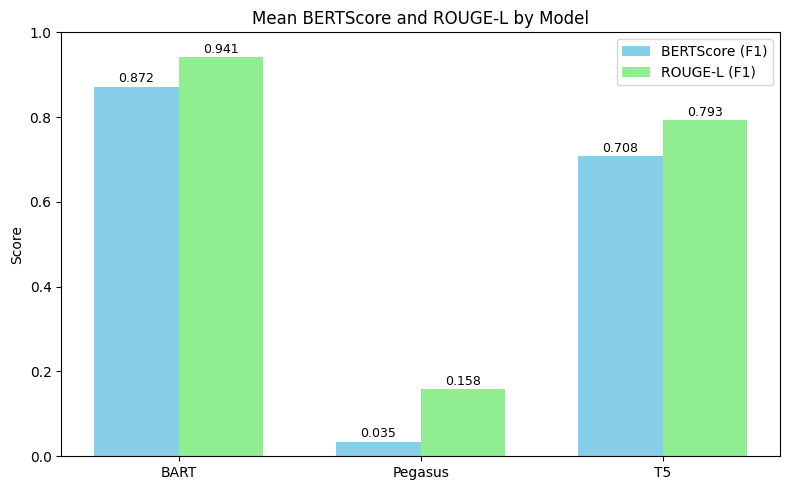

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Mean scores ---
model_names = ['BART', 'Pegasus', 'T5']
bert_f1_means = [
    np.mean(bart_f1.numpy()),
    np.mean(pegasus_f1.numpy()),
    np.mean(t5_f1.numpy())
]
rouge_l_means = [
    np.mean(bart_rouge_l),
    np.mean(pegasus_rouge_l),
    np.mean(t5_rouge_l)
]

# --- Bar Plot ---
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, bert_f1_means, width, label='BERTScore (F1)', color='skyblue')
bar2 = ax.bar(x + width/2, rouge_l_means, width, label='ROUGE-L (F1)', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Mean BERTScore and ROUGE-L by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
plt.ylim(0, 1)

# Add value labels on bars
for bars in [bar1, bar2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


/tmp/ipython-input-14-1285599244.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="BERTScore_F1", data=viz_df, palette="Blues")


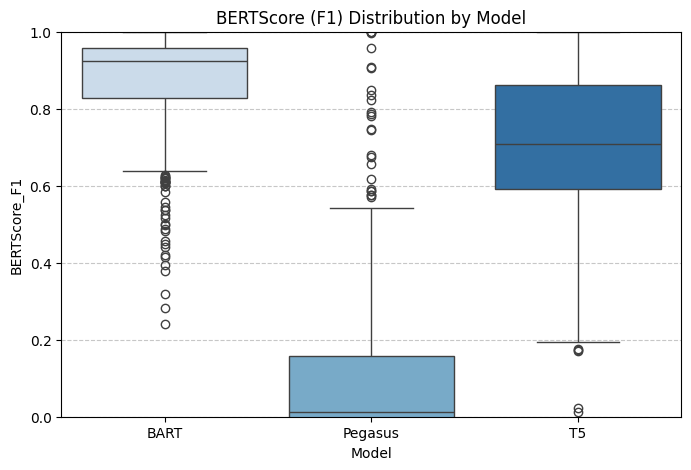

/tmp/ipython-input-14-1285599244.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="ROUGE_L_F1", data=viz_df, palette="Greens")


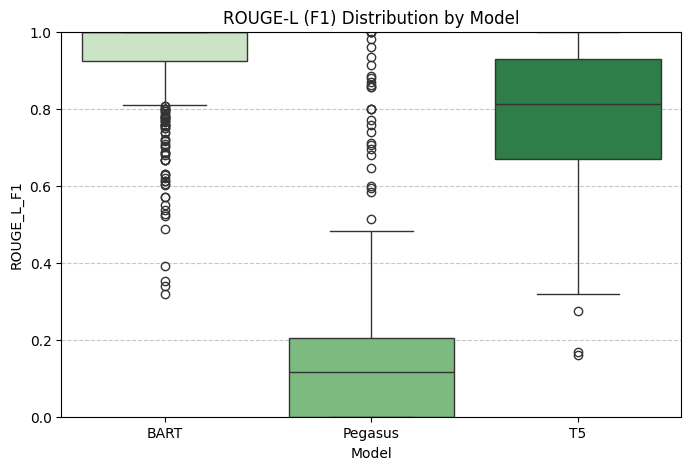

In [14]:
# Prepare data for boxplot
viz_df = pd.DataFrame({
    "Model": ["BART"] * len(bart_f1) + ["Pegasus"] * len(pegasus_f1) + ["T5"] * len(t5_f1),
    "BERTScore_F1": bart_f1.tolist() + pegasus_f1.tolist() + t5_f1.tolist(),
    "ROUGE_L_F1": bart_rouge_l + pegasus_rouge_l + t5_rouge_l
})

# Boxplot for BERTScore
plt.figure(figsize=(8, 5))
sns.boxplot(x="Model", y="BERTScore_F1", data=viz_df, palette="Blues")
plt.title("BERTScore (F1) Distribution by Model")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot for ROUGE-L
plt.figure(figsize=(8, 5))
sns.boxplot(x="Model", y="ROUGE_L_F1", data=viz_df, palette="Greens")
plt.title("ROUGE-L (F1) Distribution by Model")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [16]:
# Add scores to df_clean
df["BART_BERTScore_F1"] = bart_f1.tolist()
df["Pegasus_BERTScore_F1"] = pegasus_f1.tolist()
df["T5_BERTScore_F1"] = t5_f1.tolist()

# Top 5 tweets for each model
top_bart = df.sort_values("BART_BERTScore_F1", ascending=False).head(5)
top_pegasus = df.sort_values("Pegasus_BERTScore_F1", ascending=False).head(5)
top_t5 = df.sort_values("T5_BERTScore_F1", ascending=False).head(5)

# Show results
print("🔹 Top 5 BART Summaries:")
display(top_bart[["Tweets", "BART_Summary", "BART_BERTScore_F1"]])

print("\n🔹 Top 5 Pegasus Summaries:")
display(top_pegasus[["Tweets", "Pegasus_Summary", "Pegasus_BERTScore_F1"]])

print("\n🔹 Top 5 T5 Summaries:")
display(top_t5[["Tweets", "T5_Summary", "T5_BERTScore_F1"]])


🔹 Top 5 BART Summaries:


,Tweets,BART_Summary,BART_BERTScore_F1
365,badda is under attack indian raw are fully act...,badda is under attack indian raw are fully act...,1.000000
516,you are watching over a million ppl marching o...,you are watching over a million ppl marching o...,1.000000
457,it is a matter of great regret that our 50 pro...,it is a matter of great regret that our 50 pro...,0.985886
446,you can kill arrest harass abduct students but...,you can kill arrest harass abduct students but...,0.985110
252,bangladesh is not safe at this moment anymore ...,bangladesh is not safe at this moment anymore ...,0.984622



🔹 Top 5 Pegasus Summaries:


,Tweets,Pegasus_Summary,Pegasus_BERTScore_F1
334,how mafia having and her gangs killed our brot...,how mafia having and her gangs killed our brot...,1.000001
506,lawyers and teachers of jahangirnagar universi...,Lawyers and teachers of jahangirnagar universi...,0.999675
92,if the graffiti on the walls turns into maps i...,If the graffiti on the walls turns into maps i...,0.999496
283,a zombie movie scene nits our bangladesh,A zombie movie scene nits our bangladesh,0.997405
348,we have given blood we will give more injustic...,We have given blood we will give more injustic...,0.956797



🔹 Top 5 T5 Summaries:


,Tweets,T5_Summary,T5_BERTScore_F1
56,a month of celebration of the victory of bangl...,a month of celebration of the victory of bangl...,1.0
142,please speak about bangladesh use your platfor...,please speak about bangladesh use your platfor...,1.0
121,july massacre 2024 we will never forget our se...,july massacre 2024 we will never forget our se...,1.0
15,please speak about bangladesh use your platfor...,please speak about bangladesh use your platfor...,1.0
177,death toll is mounting in bangladesh at least ...,death toll is mounting in bangladesh at least ...,1.0


In [17]:
top_results_df = pd.concat([
    top_bart[["Tweets", "BART_Summary", "BART_BERTScore_F1"]],
    top_pegasus[["Tweets", "Pegasus_Summary", "Pegasus_BERTScore_F1"]],
    top_t5[["Tweets", "T5_Summary", "T5_BERTScore_F1"]],
], axis=0)

top_results_df.to_csv("Top_Summaries_By_BERTScore.csv", index=False)
print("✅ Top 5 summaries for each model saved to 'Top_Summaries_By_BERTScore.csv'")


✅ Top 5 summaries for each model saved to 'Top_Summaries_By_BERTScore.csv'
